# Insert Cool Name Here (Music Throughout the Decades: An Analysis) Or Something 

##  Sarah Flores & Premvanti Patel, UMD CMSC320, Fall 2020 

## Table of Contents:
1. Introduction
2. Data Collection & Processing <br>
    A. Scraping Billboard Top 100 Data <br>
    B. Cleaning the Databases <br> 
    C  Sampling Songs <br>
    D. Scraping Lyrics from Genius <br> 
3. Exploratory Analysis and Data Visualization <br>
    A. Acoustic Features <br>
4. Machine Learning **(maybe we dont need a separate section for this? We could just extend the exploratory analysis part since we probably want to make vis based on the sentinent analysis)**
5. Insights and Policy Decisions 
6. Conclusion and Further Exploration

## 1. Introduction 
It is no secret that over the past few decades, people's taste in music has evolved greatly. With this project, we want to explore those changes quantitatively, and more deeply than just finding the most popular genre. There were a few criteria we had to consider in this: how to find the most popular songs, and how exactly to put numbers to music.

While searching, we found a [database](https://data.world/kcmillersean/billboard-hot-100-1958-2017) that would serve our purposes perfectly. It combined the Billboard Top 100 weekly singles from 1958 to 2017, as well as each singles corresponding acoustic features from Spotify.

The Billboard Top 100 needs no explanation, but Spotify's acoustic features do. In 2015, [Spotify bought a small company named The Echo Nest](https://www.musicbusinessworldwide.com/spotify-acquired-echo-nest-just-e50m/) , who had designed an algorithm that classified songs into numerical acoustic features. These features include some obvious ones, such as key and time signature, but also more nuanced fields such as acousticness, danceability, and energy **(change out these features for the ones we end up analyzing)**. More information about these features, including a complete list and explanation of each, can be found [here.](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/)

To give ourselves a bit of a challenge and deepen the analysis even more, we decided to analyze the sentiment of the lyrics of the most popular song every year in between 1960 and 2010. **(Change that sentence based on how we actually write the code)**. With this, we'll also be able to cross-check this against the acoustic features in the database and see if we can find some patterns between the two that maybe even span across time.

Here is a list of the Python packages we needed for this project.
1. [Numpy](https://numpy.org/doc/stable/reference/index.html)
2. [Pandas](https://pandas.pydata.org/docs/reference/index.html)
3. [LyricsGenius](https://github.com/johnwmillr/LyricsGenius#usage)
4. [Datetime](https://docs.python.org/3/library/datetime.html)
4. Some sentiment analysis ones I haven't added yet, and

## 2. Data Collection and Processing 

### 2A. Scraping Billboard Top 100 Data

As mentioned above, we are using databases with Billboards top 100 weekly songs created by <a href="https://data.world/kcmillersean/billboard-hot-100-1958-2017">Sean Miller</a>. All of the libraries necessary to complete this tutorial are imported below. 

In [1]:
import numpy as np
import pandas as pd
import datetime

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# scraping lyrics 
!pip install lyricsgenius
import lyricsgenius

     |████████████████████████████████| 46 kB 1.5 MB/s eta 0:00:01


In [2]:
# Read into dataframes
features_df = pd.read_csv('Hot 100 Audio Features.csv')
ranks_df = pd.read_csv('Hot Stuff.csv')

# make copies
features = features_df.copy(deep=True)
ranks = ranks_df.copy(deep=True)

In [3]:
ranks.head()

,url,WeekID,Week Position,Song,Performer,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart
0,http://www.billboard.com/charts/hot-100/1958-0...,8/2/1958,1,Poor Little Fool,Ricky Nelson,Poor Little FoolRicky Nelson,1,NaN,1,1
1,http://www.billboard.com/charts/hot-100/1995-1...,12/2/1995,1,One Sweet Day,Mariah Carey & Boyz II Men,One Sweet DayMariah Carey & Boyz II Men,1,NaN,1,1
2,http://www.billboard.com/charts/hot-100/1997-1...,10/11/1997,1,Candle In The Wind 1997/Something About The Wa...,Elton John,Candle In The Wind 1997/Something About The Wa...,1,NaN,1,1
3,http://www.billboard.com/charts/hot-100/2006-0...,7/1/2006,1,Do I Make You Proud,Taylor Hicks,Do I Make You ProudTaylor Hicks,1,NaN,1,1
4,http://www.billboard.com/charts/hot-100/2009-1...,10/24/2009,1,3,Britney Spears,3Britney Spears,1,NaN,1,1


In the Ranks dataset shown above, there are 10 columns. They tell us how a song ranked in comparison to other songs that year. The attributes provided are:
- Billboard Chart URL
- WeekID
- Song name
- Performer name
- SongID - Concatenation of song & performer
- Current week on chart
- Instance (this is used to separate breaks on the chart for a given song. Example, an instance of 6 tells you that this is the sixth time this song has appeared on the chart)
- Previous week position
- Peak Position (as of the corresponding week)
- Weeks on Chart (as of the corresponding week)

In [4]:
features.head()

,SongID,Performer,Song,spotify_genre,spotify_track_id,spotify_track_preview_url,spotify_track_album,spotify_track_explicit,spotify_track_duration_ms,spotify_track_popularity,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,"AdictoTainy, Anuel AA & Ozuna","Tainy, Anuel AA & Ozuna",Adicto,['pop reggaeton'],3jbT1Y5MoPwEIpZndDDwVq,NaN,Adicto (with Anuel AA & Ozuna),False,270740.0,91.0,...,10.0,-4.803,0.0,0.0735,0.01700,0.000016,0.1790,0.623,80.002,4.0
1,The Ones That Didn't Make It Back HomeJustin M...,Justin Moore,The Ones That Didn't Make It Back Home,"['arkansas country', 'contemporary country', '...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ShallowLady Gaga & Bradley Cooper,Lady Gaga & Bradley Cooper,Shallow,"['dance pop', 'pop']",2VxeLyX666F8uXCJ0dZF8B,NaN,A Star Is Born Soundtrack,False,215733.0,88.0,...,7.0,-6.362,1.0,0.0308,0.37100,0.000000,0.2310,0.323,95.799,4.0
3,EnemiesPost Malone Featuring DaBaby,Post Malone Featuring DaBaby,Enemies,"['dfw rap', 'melodic rap', 'rap']",0Xek5rqai2jcOWCYWJfVCF,NaN,Hollywood's Bleeding,True,196760.0,86.0,...,6.0,-4.169,1.0,0.2100,0.05880,0.000000,0.0955,0.667,76.388,4.0
4,"Bacc At It AgainYella Beezy, Gucci Mane & Quavo","Yella Beezy, Gucci Mane & Quavo",Bacc At It Again,"['dfw rap', 'rap', 'southern hip hop', 'trap']",2biNa12dMbHJrHVFRt8JyO,https://p.scdn.co/mp3-preview/fa6fa6f6f363be29...,Bacc At It Again,True,228185.0,61.0,...,8.0,-5.725,0.0,0.1680,0.00124,0.000001,0.0716,0.856,135.979,4.0


In the Features dataset shown above, we have 22 columns. The first 10 columns provide basic information on the song like its title and performer. They also include Spotify specific details like track id and popularity. The SongID, Song, and Perfomer columns are repeated from the Ranks dataset. These columns are important for connecting the Rank and Features databases. The remaining 12 columns describe the acoustic features of each song. To learn more about what each acoustic feature signifies, check out this <a href="https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/">spec</a> created by Spotify. 

### 2B. Cleaning the Databases

Here, we are going to combine our Ranks and Features dataframes, add new columns, delete unnecessary columns, and remove duplicate songs. Because the Ranks database contains the top 100 songs of every week, there will be popular songs that show up multiple times. For example, some songs may rank number 1 multiple weeks in the year. We want to delete duplicate songs because we will not be looking at the frequency in which particular songs, genres, or artists occur but rather how the acoustic features of these songs relate to their lyrics. 

Along with cleaning our databases, we want to take a sample of the songs for sentiment analysis. 
**(Explain why were are sampling and how, or should that explanation come in a different place?) **

In [24]:
# I am thinking that this should be done after the databases are merged so that the code flows a bit smoother, 
# I dont want to do it yet so I dont accidentally mess up the lyric scraping method that relies on this


# Explain why we want to add a Datetime column 
# Ranks preprocessing
dt = []
for row_index, row in ranks.iterrows():
    temp = datetime.datetime.strptime(ranks.at[row_index, 'WeekID'], '%m/%d/%Y')
    dt.append(temp)
ranks['Datetime'] = dt

ranks = ranks.sort_values(by=['Datetime', 'Week Position'])

We want to start off by merging our Ranks and Features databases. These databases are connected by their SongID, so we will be merging on that column. We only want to analyze songs that are present in both dataframes so we will be performing an inner join. 

In [11]:
# merge ranks and features dataframe 
songs = pd.merge(ranks, features, on='SongID', how='inner')

# remove columns that we wont use 
cols_remove = ['Performer_y', 'Song_y', 'Weeks on Chart', 'Peak Position', 'Previous Week Position', 'Instance']
songs.drop(cols_remove, axis = 1, inplace=True)

songs.rename(columns={"Performer_x": "Performer", "Song_x": "Song"}, inplace=True)

# remove rows with duplicate SongIDs 
songs = songs.drop_duplicates(subset='SongID', keep="first")
songs.reset_index(drop=True, inplace=True)

# add a separate row with only the year
# doing this will help us create visualizations later
years = []
for row_index, row in songs.iterrows(): 
    years.append(row["Datetime"].year)
    
songs['Year'] = years

In [12]:
songs.head()

,url,WeekID,Week Position,Song,Performer,SongID,Datetime,spotify_genre,spotify_track_id,spotify_track_preview_url,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Year
0,http://www.billboard.com/charts/hot-100/1958-0...,8/2/1958,4,Hard Headed Woman,Elvis Presley With The Jordanaires,Hard Headed WomanElvis Presley With The Jordan...,1958-08-02,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1958
1,http://www.billboard.com/charts/hot-100/1958-0...,8/2/1958,5,When,Kalin Twins,WhenKalin Twins,1958-08-02,"['doo-wop', 'rock-and-roll']",1BQOMZeYwzesvXANmRgrEp,https://p.scdn.co/mp3-preview/44ee64051857250e...,...,-12.679,1.0,0.0297,0.1680,0.000005,0.976,0.963,96.490,4.0,1958
2,http://www.billboard.com/charts/hot-100/1958-0...,8/2/1958,7,Yakety Yak,The Coasters,Yakety YakThe Coasters,1958-08-02,"['brill building pop', 'bubblegum pop', 'doo-w...",7demHL0GXA6YmTNqw3Btz8,https://p.scdn.co/mp3-preview/979ed69d82eee4eb...,...,-9.491,1.0,0.1280,0.7050,0.000732,0.044,0.976,120.789,4.0,1958
3,http://www.billboard.com/charts/hot-100/1958-0...,8/2/1958,8,My True Love,Jack Scott,My True LoveJack Scott,1958-08-02,"['brill building pop', 'deep adult standards',...",2Un1O9CChp4wyTmt422XwW,https://p.scdn.co/mp3-preview/f3bd2075b9a97208...,...,-11.387,1.0,0.0279,0.8710,0.000099,0.138,0.238,68.184,3.0,1958
4,http://www.billboard.com/charts/hot-100/1958-0...,8/2/1958,9,Willie And The Hand Jive,The Johnny Otis Show,Willie And The Hand JiveThe Johnny Otis Show,1958-08-02,NaN,6ouc29xdKVscjfuqv7oDxN,https://p.scdn.co/mp3-preview/7b87d2e3ab232de2...,...,-15.751,1.0,0.0577,0.0453,0.327000,0.143,0.957,100.755,4.0,1958


### 2C. Sampling Songs

Now that we have cleaned up our database by adding useful columns, deleting unnecessary ones, and merging our rank and features databases, lets start preparing the Songs database for sampling. Our Songs database contains information the weekly rankings from 1958 to 2019. Let's focus on decades that are represented entirely in our database. We will remove songs from the 50s and late 2000s. **(Should we explain why we do this?)**

In [13]:
songs_sample= songs.copy(deep=True)
songs_sample.reset_index(drop=True, inplace=True)

# create an array of years (50s, 2010s)
years_1 = np.arange(1958, 1960)
years_2 = np.arange(2011, 2020)
years_removed = np.concatenate((years_1, years_2), axis=None)

# store the indices of rows in Songs database with years we do not want
bad_rows = []
for row_index, row in songs_sample.iterrows(): 
    if row['Datetime'].year in years_removed:
        bad_rows.append(row_index)
    
# remove decades that arent complete (50s, 2010s)
songs_sample.drop(songs_sample.index[bad_rows], inplace=True)
songs_sample.reset_index(drop=True, inplace=True)

In [16]:
songs_sample

,url,WeekID,Week Position,Song,Performer,SongID,Datetime,spotify_genre,spotify_track_id,spotify_track_preview_url,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Year
0,http://www.billboard.com/charts/hot-100/1960-0...,1/2/1960,68,Crazy Arms,Bob Beckham,Crazy ArmsBob Beckham,1960-01-02,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1960
1,http://www.billboard.com/charts/hot-100/1960-0...,1/2/1960,78,Skokiaan (South African Song),Bill Haley And His Comets,Skokiaan (South African Song)Bill Haley And Hi...,1960-01-02,"['adult standards', 'brill building pop', 'doo...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1960
2,http://www.billboard.com/charts/hot-100/1960-0...,1/2/1960,82,Rockin' Little Angel,Ray Smith,Rockin' Little AngelRay Smith,1960-01-02,"['rock-and-roll', 'rockabilly']",1R4kAzLGI0PQBe32NAGP40,https://p.scdn.co/mp3-preview/ab8c5d25a04cb0dd...,...,-5.065,1.0,0.0796,0.8040,0.000002,0.1350,0.9620,79.156,4.0,1960
3,http://www.billboard.com/charts/hot-100/1960-0...,1/2/1960,84,Tracy's Theme,Spencer Ross,Tracy's ThemeSpencer Ross,1960-01-02,[],NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1960
4,http://www.billboard.com/charts/hot-100/1960-0...,1/2/1960,87,Riverboat,Faron Young,RiverboatFaron Young,1960-01-02,"['classic country pop', 'honky tonk', 'rockabi...",1LXTz7SxX7C7SCoFpz0Tc2,NaN,...,-8.817,1.0,0.0490,0.4910,0.000000,0.0990,0.9420,90.851,4.0,1960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23511,http://www.billboard.com/charts/hot-100/2010-1...,12/25/2010,59,Welcome Christmas,Glee Cast,Welcome ChristmasGlee Cast,2010-12-25,"['glee club', 'hollywood', 'post-teen pop']",453OW4naq3cgZlk9oaHCu9,https://p.scdn.co/mp3-preview/802b81ffd968fcf2...,...,-9.302,1.0,0.0297,0.9110,0.000000,0.2750,0.0819,110.822,4.0,2010
23512,http://www.billboard.com/charts/hot-100/2010-1...,12/25/2010,68,Rolling In The Deep,Adele,Rolling In The DeepAdele,2010-12-25,"['british soul', 'pop', 'uk pop']",1CkvWZme3pRgbzaxZnTl5X,https://p.scdn.co/mp3-preview/8c174ce25d94b502...,...,-5.119,1.0,0.0294,0.1310,0.000000,0.0527,0.5220,104.945,4.0,2010
23513,http://www.billboard.com/charts/hot-100/2010-1...,12/25/2010,89,No BS,Chris Brown,No BSChris Brown,2010-12-25,"['dance pop', 'pop', 'pop rap', 'r&b', 'rap']",6P3cUSAoT4EeMxVgWVdBra,https://p.scdn.co/mp3-preview/4b3158b2f9d396b8...,...,-6.359,0.0,0.0567,0.1200,0.000000,0.1190,0.1060,172.171,4.0,2010
23514,http://www.billboard.com/charts/hot-100/2010-1...,12/25/2010,94,Bass Down Low,Dev Featuring The Cataracs,Bass Down LowDev Featuring The Cataracs,2010-12-25,"['dance pop', 'electropop']",4Xf7EL8G6FRYwvJADl0nf4,NaN,...,-8.022,1.0,0.0628,0.0886,0.000000,0.0499,0.8340,113.035,4.0,2010


Now, we want to select songs from our subset of years for seninent analysis

**(give an explanation of how we are going to sample)** 

In [ ]:
# insert code to do this here

### 2D. Sraping Lyrics from Genius 

<b> Insert explanation </b>

In [17]:
genius = lyricsgenius.Genius('EJqlckWu_h-lDQ8fVR8XOHpKJuEPV1liGiavTav-Y5y1QC1OrUy6AqYFD-VHl8YC')
genius.verbose = False
genius.remove_section_headers = True # Remove section headers (e.g. [Chorus]) from lyrics when searching

In [18]:
artist = genius.search_artist("Andy Shauf", max_songs=3, sort="title")
song = artist.song("Alexander All Alone")
song2 = genius.search_song("Alexander All Alone", artist.name)

In [19]:
# can access it in two ways
print(song.lyrics)
print(song2.lyrics)

Alexander all alone
Smoking a cigarette
The last pack he’d ever buy
At least that’s what he said
He stood up to stretch his back
And fell down to the ground

Alexander all alone
'Till the neighbour caught a glimpse
Cried out for his wife
To call the ambulance
Alexander all alone
Felt them check his pulse
He heard them pronounce him dead

Hell is found inside of me
And nothing else will set me free
If hell is found inside of me
Then open me up and spill me out

Alexander wondered why
No life flashed before his eyes
Why his soul did not depart
Why he found no peace of mind
Would it take a little while?
Was it the same for everyone?
Alexander realized

That hell is found inside of me
And nothing else will set me free
If hell is found inside of me
Then open me up and spill me out
Alexander all alone
Smoking a cigarette
The last pack he’d ever buy
At least that’s what he said
He stood up to stretch his back
And fell down to the ground

Alexander all alone
'Till the neighbour caught a glimps

In [20]:
def get_lyrics(artist, song):
    return genius.search_song(song, artist).lyrics

In [21]:
testlyrics = get_lyrics(ranks.at[0, 'Song'], ranks.at[0, 'Performer'])
print(testlyrics)
# could use package zlib to compress the lyrics, unsure whether or not to, yet

I used to play around with hearts
That hastened at my call
But when I met that little girl
I knew that I would fall
Poor little fool, oh yeah
I was a fool, uh huh
(Oh oh, poor little fool)
(I was a fool, oh yeah)
She played around and teased me
With her carefree devil eyes
She'd hold me close and kiss me
But her heart was full of lies
Poor little fool, oh yeah
I was a fool, uh huh
(Oh oh, poor little fool)
(I was a fool, oh yeah)
She told me how she cared for me
And that we'd never part
And so for the very first time
I gave away my heart
Poor little fool, oh yeah
I was a fool, uh huh
(Oh oh, poor little fool)
(I was a fool, oh yeah)
The next day she was gone
And I knew she'd lied to me
She left me with a broken heart
And won her victory
Poor little fool, oh yeah
I was a fool, uh huh
(Oh oh, poor little fool)
(I was a fool, oh yeah)
Well, I'd played this game with other hearts
But I never thought I'd see
The day that someone else would play
Love's foolish game with me
Poor little fool, 

## 3. Exploratory Analysis and Data Visualization

### 3A. Acoustic Features

Lets look at how different acoustic features change over the years! We are going to look at the Songs database here, which has information on all the songs from 1958 to 2019 and their corresponding acoustic features. Instead of only analyzing the acoustic features of songs from 1960 to 2010, like in the sample we took, we are going to analyze all of the years given. This wil give us some interesting results on the relationship between acoustic features and year!

We will be examining the following features for relationships to year: acousticness, danceability, energy, instrumentalness, liveness, loudness, speechiness, valence, and tempo. We will not be examining mode, time signature, and key because <b> (insert explanation here) </b>

For a reminder on what each of the the acoustic features means, check out this [page.](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/)

In [22]:
# find the average of each feature per year
df = songs.copy()

acoustic_features = ['danceability','energy', 'key', 'loudness',
                     'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
                     'valence', 'tempo', 'time_signature']

feature_averages = df.groupby(["Year"])[acoustic_features].mean()
feature_averages.reset_index(inplace=True)

feature_averages.head()

,Year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,1958,0.546345,0.483981,5.113537,-10.650773,0.864629,0.055173,0.686833,0.060413,0.202426,0.682537,114.175406,3.724891
1,1959,0.524812,0.468642,4.989247,-11.270876,0.846774,0.059139,0.668376,0.062089,0.187390,0.652536,117.312718,3.793011
2,1960,0.509136,0.452610,5.101942,-10.905500,0.861650,0.047097,0.672980,0.069516,0.210738,0.636658,116.481352,3.771845
3,1961,0.526943,0.484704,4.922131,-10.405340,0.870902,0.054827,0.662304,0.081132,0.219823,0.666345,117.781158,3.778689
4,1962,0.542443,0.473442,5.202505,-10.951973,0.862213,0.057666,0.640543,0.072739,0.213533,0.665704,118.460150,3.795407


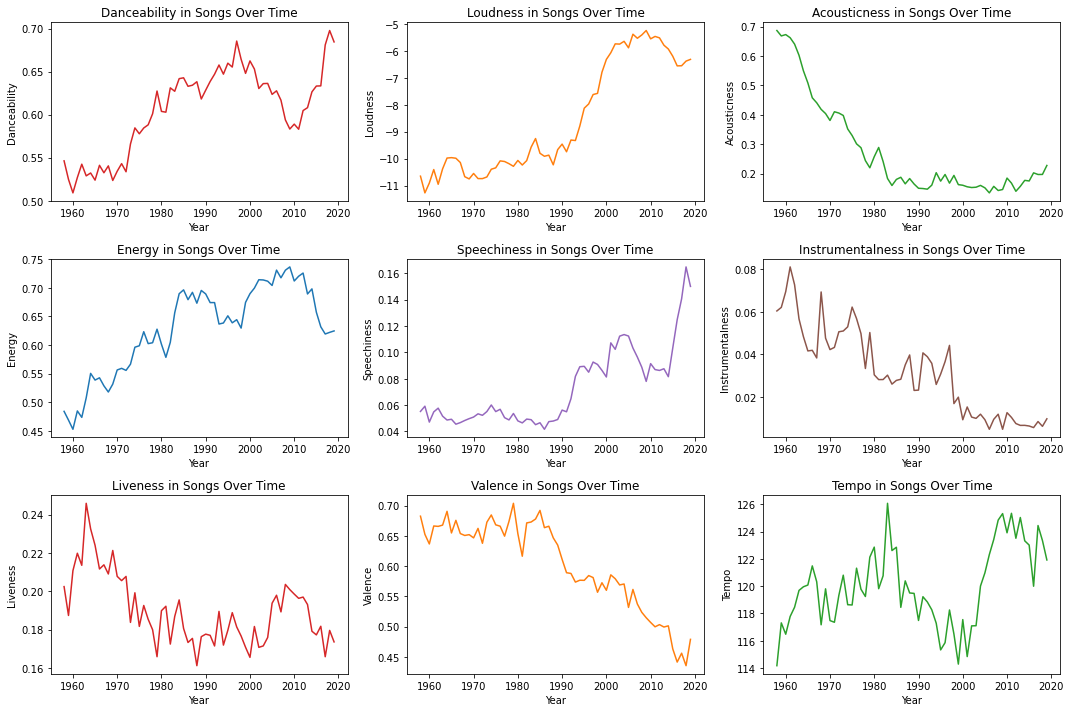

In [23]:
# Generate Plots
fig, axs = plt.subplots(3, 3, figsize=(15,10))

x = feature_averages['Year']

# Plot Danceability
axs[0, 0].plot(x, feature_averages['danceability'],  'tab:red')
axs[0, 0].set_title("Danceability in Songs Over Time")
axs[0, 0].set(ylabel='Danceability')

# Plot Loudness
axs[0, 1].plot(x, feature_averages['loudness'], 'tab:orange')
axs[0, 1].set_title("Loudness in Songs Over Time")
axs[0, 1].set(ylabel='Loudness')

# Plot Acousticness
axs[0, 2].plot(x, feature_averages['acousticness'], 'tab:green')
axs[0, 2].set_title("Acousticness in Songs Over Time")
axs[0, 2].set(ylabel='Acousticness')

# Plot Energy
axs[1, 0].plot(x, feature_averages['energy'], 'tab:blue')
axs[1, 0].set_title("Energy in Songs Over Time")
axs[1, 0].set(ylabel='Energy')

# Plot Speechiness 
axs[1, 1].plot(x, feature_averages['speechiness'], 'tab:purple')
axs[1, 1].set_title("Speechiness in Songs Over Time")
axs[1, 1].set(ylabel='Speechiness')

# Plot Instrumentalness
axs[1, 2].plot(x, feature_averages['instrumentalness'], 'tab:brown')
axs[1, 2].set_title("Instrumentalness in Songs Over Time")
axs[1, 2].set(ylabel='Instrumentalness')

# Plot Liveness
axs[2, 0].plot(x, feature_averages['liveness'], 'tab:red')
axs[2, 0].set_title("Liveness in Songs Over Time")
axs[2, 0].set(ylabel='Liveness')

# Plot Valence
axs[2, 1].plot(x, feature_averages['valence'], 'tab:orange')
axs[2, 1].set_title("Valence in Songs Over Time")
axs[2, 1].set(ylabel='Valence')

# Plot Tempo
axs[2, 2].plot(x, feature_averages['tempo'], 'tab:green')
axs[2, 2].set_title("Tempo in Songs Over Time")
axs[2, 2].set(ylabel='Tempo')

# Set x axis labels to Year
for ax in axs.flat:
    ax.set(xlabel='Year')
    
fig.tight_layout()

#### What do this plots tell us? 

Analyzing the acoustic features of songs over time gives us interesing results. <b> (These results are) </b>

Now that we have looked at acoustic features and their relationship to time, let's take a look at the relationship between these features and the lyrics of the songs they represent. This can give us an interesting idea of how lyrics have changed over time!

**(Another thing we can do for exploration is looking at popular genres over time? That can tie in nicely to our sentinent analysis I think)**

**(Plot of unique words)**

## 4. Machine Learning 

### 4A. Sentiment Analysis 

Now that we have our song database cleaned up and created method for scraping lyrics from the web, we can move onto a sentiment analysis of the lyrics.

To do this, we will need the following packages: 

## 5. Insights and Policy Decisions

## 6. Conclusion and Further Exploration